# Imports

In [21]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import subprocess
import os

%matplotlib notebook

# Tests

## Get a list of fonts

In [2]:
from matplotlib import font_manager
from IPython.core.display import HTML
font_manager.fontManager.addfont('/home/kevin/.local/share/fonts/Polly-Regular.otf')

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in mpl.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

## Define sinusoidal curves for the different pngs

In [3]:
pngs = {Path(file): {} for file in glob('logo/*banner*png')}

offset = 0.4
nsamples = 20
xall = np.linspace(0, (np.pi + offset) * len(pngs), nsamples * len(pngs))
yall = np.full(nsamples * len(pngs), 0).astype(float)
zeros = np.full(nsamples * len(pngs), 0).astype(float)

for i, png in enumerate(pngs):
    x = np.linspace(-offset, np.pi, nsamples)
    y = np.sin(x) * 1.05
    y[y>1] = 1
    y[x < 0] = 0
    x += offset
    yall[i * nsamples:i*nsamples + nsamples] = y
    zeros[i * nsamples:i*nsamples + nsamples] = y
    pngs[png]['x'] = xall
    pngs[png]['y'] = zeros
    zeros = np.full(nsamples * len(pngs), 0).astype(float)

<IPython.core.display.Javascript object>


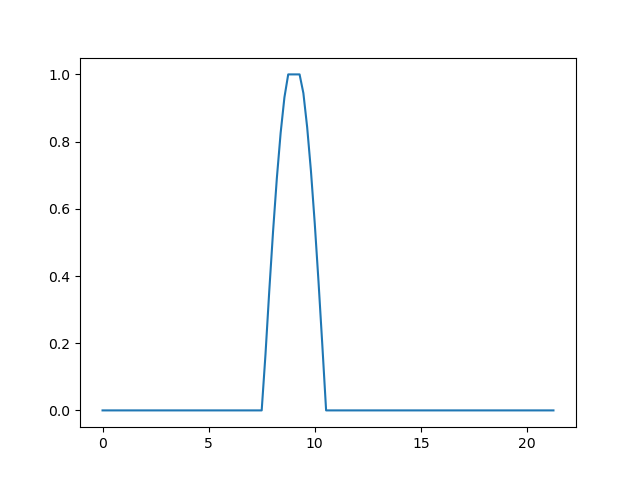

In [4]:
plt.plot(pngs[Path('logo/github_banner_molecule.png')]['x'], pngs[Path('logo/github_banner_molecule.png')]['y'])

## Test animation

<IPython.core.display.Javascript object>


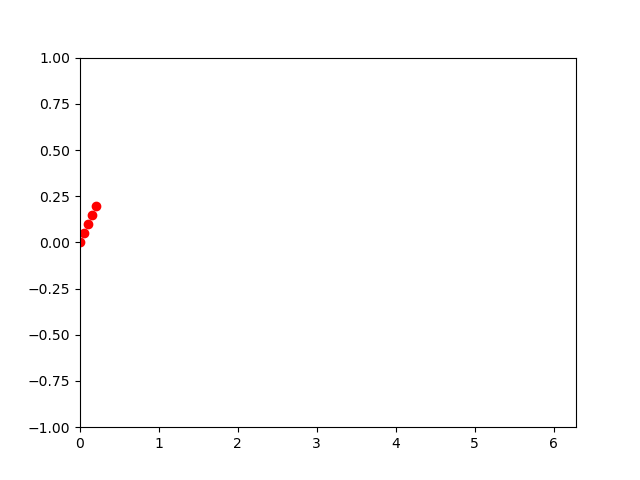

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

# Plotting

<IPython.core.display.Javascript object>


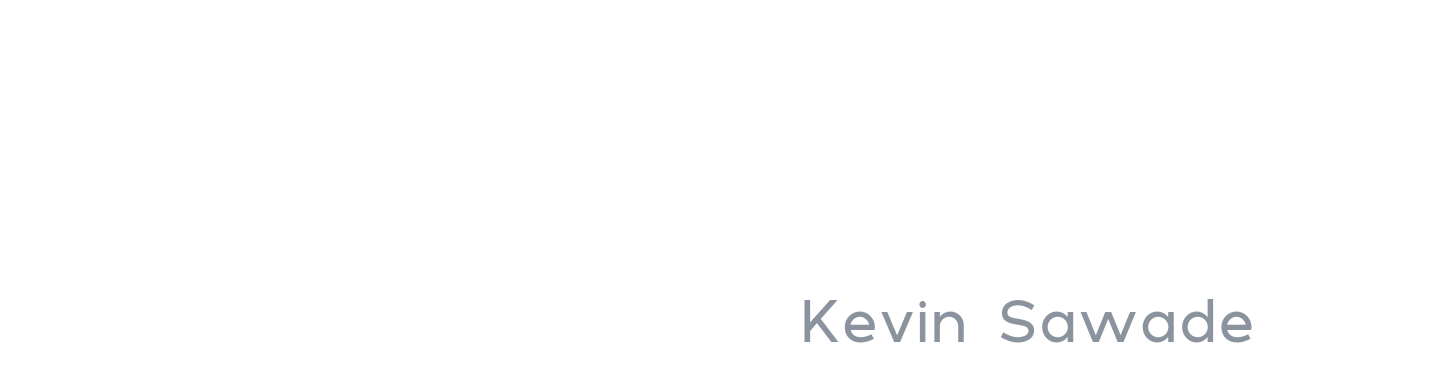

Version: ImageMagick 6.9.10-23 Q16 x86_64 20190101 https://imagemagick.org
Copyright: © 1999-2019 ImageMagick Studio LLC
License: https://imagemagick.org/script/license.php
Features: Cipher DPC Modules OpenMP 
Delegates (built-in): bzlib djvu fftw fontconfig freetype jbig jng jpeg lcms lqr ltdl lzma openexr pangocairo png tiff webp wmf x xml zlib
Usage: convert-im6.q16 [options ...] file [ [options ...] file ...] [options ...] file

Image Settings:
  -adjoin              join images into a single multi-image file
  -affine matrix       affine transform matrix
  -alpha option        activate, deactivate, reset, or set the alpha channel
  -antialias           remove pixel-aliasing
  -authenticate password
                       decipher image with this password
  -attenuate value     lessen (or intensify) when adding noise to an image
  -background color    background color
  -bias value          add bias when convolving an image
  -black-point-compensation
                       use bla

In [22]:
from matplotlib import font_manager
from matplotlib.animation import FuncAnimation, PillowWriter
font_manager.fontManager.addfont('/home/kevin/.local/share/fonts/Polly-Regular.otf')

# settings
dpi = 200
canvas_width = 1456
canvas_height = 385
offset = 0.4
nsamples = 20

# constants
bg_color = '#21262d'
fg_color = '#8b949e'
highlight_color1 = '#cccccc'
highlight_color2 = '#ffffff'

# prepare data
pngs = {Path(file): {} for file in glob('logo/*banner*png')}

xall = np.linspace(0, (np.pi + offset) * len(pngs), nsamples * len(pngs))
frames = np.arange(nsamples * len(pngs))
yall = np.full(nsamples * len(pngs), 0).astype(float)
zeros = np.full(nsamples * len(pngs), 0).astype(float)

for i, png in enumerate(pngs):
    x = np.linspace(-offset, np.pi, nsamples)
    y = np.sin(x) * 1.05
    y[y>1] = 1
    y[x < 0] = 0
    x += offset
    yall[i * nsamples:i*nsamples + nsamples] = y
    zeros[i * nsamples:i*nsamples + nsamples] = y
    pngs[png]['x'] = xall
    pngs[png]['y'] = zeros
    # reset zeros
    zeros = np.full(nsamples * len(pngs), 0).astype(float)
    pngs[png]['img'] = plt.imread(png)
    index = pngs[png]['img'][..., -1] != 0
    pngs[png]['index'] = index
    
# create the figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(canvas_width/dpi, canvas_height/dpi), dpi=dpi)
ax2.set_position([0, 0, 0.5, 1])

# prepare the ax
ax1.axis('off')
ax1.set_zorder(5)
ax2.axis('off')
ax2.set_zorder(-5)
# fig.patch.set_facecolor(bg_color)

# create as many axes as there are pngs
axes = [fig.add_subplot(ax1.get_subplotspec()) for png in pngs]
[ax.axis('off') for ax in axes]

# add the Kevin Sawade Text
text = ax2.text(800, 29, 'Kevin Sawade', ha='left', va='bottom', c=fg_color, transform=None, fontdict={'size': 22, 'family': 'Polly'})

# create iterable of imshows
ims = [ax.imshow(png['img']) for ax, png in zip(axes, pngs.values())]

def init():
    out_ims = []
    for im in ims:
        ar = im.get_array()
        ar[..., -1] = 0
        im.set_array(ar)
        out_ims.append(im)
    return out_ims


def animate(i):
    out_ims = []
    for png, im in zip(pngs, ims):
        ar = pngs[png]['img']
        alpha = pngs[png]['y'][i]
        ar[pngs[png]['index'], -1] = alpha
        im.set_array(ar)
        out_ims.append(im)
    return out_ims
        

# ani = FuncAnimation(fig, animate, frames=frames,
#                     init_func=init, blit=True, interval=5,
#                     repeat=False)
# ani.save("logo/frames/anim.png", writer="imagemagick", dpi=dpi)
# ani.save("logo/movie.gif", writer=PillowWriter(fps=5), )
init()

for i in frames:
    if not os.path.isfile(f"logo/frames/anim_{i:03d}.png"):
        animate(i)
        plt.savefig(f"logo/frames/anim_{i:03d}.png", transparent=True)
    
args = ['convert', "-delay", "10", "-loop" , "0", "-dispose", "Background", "logo/frames/anim_*.png", "logo/movie.gif"]
subprocess.call(args, shell=True)

plt.show()

In [18]:
pngs.keys()

dict_keys([PosixPath('logo/github_banner_beaker.png'), PosixPath('logo/github_banner_brain.png'), PosixPath('logo/github_banner_hpc.png'), PosixPath('logo/github_banner_magnifying.png'), PosixPath('logo/github_banner_map.png'), PosixPath('logo/github_banner_molecule.png'), PosixPath('logo/github_banner_network.png'), PosixPath('logo/github_banner_flask.png')])